### Import CSV and Required Packages

# Classification after Clustering with Agglomerative Clustering

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay


pd.pandas.set_option("display.max_columns", None)

In [71]:
# Create Dataframe
df = pd.read_csv(r"clustered_data.csv")

# Print shape of dataset
print(df.shape)

(2240, 22)


**Split X and y**


In [72]:
X = df.drop("cluster", axis=1) #dropping the target column which is 'cluster'
y = df["cluster"]

In [73]:
# Separate data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape

(1568, 21)

## Grid Search


## Select the best model
- so here we have some list of the best classification algorithms we imported. Now we will compare each model's score and see which model is performing better than rest of the others

In [74]:

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve,confusion_matrix
from xgboost import XGBClassifier
from sklearn import metrics

models = {
    "Random Forest": RandomForestClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Logistic Regression": LogisticRegression(),
     "K-Neighbors Classifier": KNeighborsClassifier(),
    "XGBClassifier": XGBClassifier(),
    "AdaBoost Classifier": AdaBoostClassifier()
}

- ### We will create a generic function to check each model's performance so that we can compare those

In [75]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

def evaluate_models(X_train, X_test, y_train, y_test, models):
    """
    Evaluates classification models for cluster-label prediction
    Returns a DataFrame with standard classification metrics
    """

    results = []

    for model_name, model in models.items():

        # Train model
        model.fit(X_train, y_train)

        # Predict
        y_pred = model.predict(X_test)

        # Metrics
        results.append({
            "Model Name": model_name,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision (weighted)": precision_score(y_test, y_pred, average="weighted", zero_division=0),
            "Recall (weighted)": recall_score(y_test, y_pred, average="weighted", zero_division=0),
            "F1 Score (weighted)": f1_score(y_test, y_pred, average="weighted", zero_division=0)
        })

    return pd.DataFrame(results).sort_values(by="F1 Score (weighted)", ascending=False)

### Let's check the report

In [76]:
report = evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test, models)

In [77]:
report

,Model Name,Accuracy,Precision (weighted),Recall (weighted),F1 Score (weighted)
3,Logistic Regression,0.979167,0.979294,0.979167,0.979191
5,XGBClassifier,0.973214,0.973512,0.973214,0.973272
2,Gradient Boosting,0.967262,0.967277,0.967262,0.967266
6,AdaBoost Classifier,0.959821,0.959758,0.959821,0.959751
0,Random Forest,0.956845,0.957519,0.956845,0.956995
1,Decision Tree,0.946429,0.946848,0.946429,0.946537
4,K-Neighbors Classifier,0.933036,0.934458,0.933036,0.932501


- ### From the report above we can see that the logistic regression model performed the best, so we will continue training our model using logistic regression algorithm.

### Let's do hyperparameter tuning

In [78]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

params = {
    "solver": ["lbfgs", "newton-cg", "sag"],
    "penalty": ["l2"],   # l1 not supported by all solvers
    "C": np.logspace(-3, 3, 7),
    "max_iter": [200, 300, 400]
}

logreg = LogisticRegression()

logreg_cv = GridSearchCV(
    logreg,
    params,
    cv=10,
    scoring="accuracy",
    n_jobs=-1
)

logreg_cv.fit(X_train_scaled, y_train)

print("Best parameters:", logreg_cv.best_params_)
print("CV Accuracy:", logreg_cv.best_score_)

Best parameters: {'C': np.float64(10.0), 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}
CV Accuracy: 0.9936101584190755


### So we got our best parameters. Let's now train the model with those parameters.

In [79]:
best_model = logreg_cv.best_estimator_

y_pred = best_model.predict(X_test_scaled)

score = accuracy_score(y_test, y_pred)
cr = classification_report(y_test, y_pred)

print("Logistic Regression Final Model")
print("Accuracy Score:", score)
print(cr)

Logistic Regression Final Model
Accuracy Score: 0.9806547619047619
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       274
           1       0.99      0.98      0.98       168
           2       0.97      0.98      0.97       230

    accuracy                           0.98       672
   macro avg       0.98      0.98      0.98       672
weighted avg       0.98      0.98      0.98       672



In [80]:
joblib.dump(
    {
        "scaler": scaler,
        "model": best_model
    },
    "customer_model.pkl"
)

['customer_model.pkl']

## Confusion matrix of the model

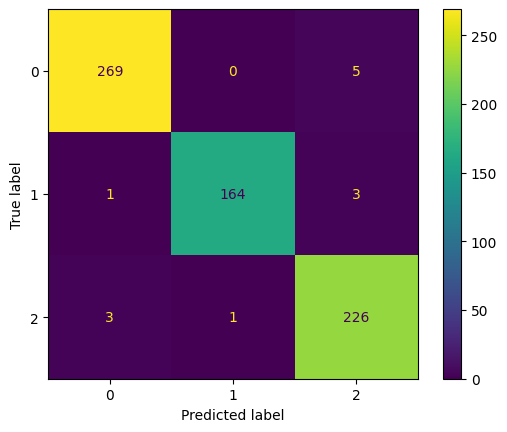

In [81]:
ConfusionMatrixDisplay.from_estimator(
    best_model,
    X_test_scaled,
    y_test
)

- **Reports**

**We can see, that the model performed pretty well.**
- we have used logistic regression as it performed well than other models
- We got a good accuracy while predicting the test dataset.